In [264]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

import gurobipy as gp
from gurobipy import GRB, tuplelist


import pandapower.networks as pn 

In [265]:
T = 96 # 하루를 15분 단위로 나눈 시간 구간 수
slackbus = [0] # 전력계통에서 전압과 위상각의 기준이 되는 슬랙버스 번호
line_lim = 3 # 송전선로의 용량 제한 (3 MVA 또는 3kW)
kVAbase = 1000 # 베이스
vmin, vmax = 0.95, 1.05
delta_t = 0.25 # Every 15 minutes
D = 500 # 수요 관련 파라미터
soh_min, soh_max = 0.7, 1 # 배터리 수명 상태 제한
soc_min, soc_max = 0.1, 0.9 # 배터리 충전 상태 제한
w_lb, w_ub = 0, 1 # 가중치 범위


<center>

## List of Parameters

| Code       | Definition                  |  
| :--------- | --------------------------- | 
| T          | Max. time steps             |  
| kVAbase    | Base power (kVA)            | 
| vmin, vmax | Minimum/maximum voltage (V) | 
|            |                             | 

In [266]:
net = pn.case33bw()
print(net)
MVAbase = kVAbase / 1000 # MVA-> 1MVA를 1pu로 사용하겠다
impbase = net.bus.vn_kv[0]**2/(MVAbase)

This pandapower network includes the following parameter tables:
   - bus (33 elements)
   - load (32 elements)
   - ext_grid (1 element)
   - line (37 elements)
   - poly_cost (1 element)


In [267]:
# Line Data
frombus,tobus = [],[]
for i in net.line.index:
    frombus.append(net.bus.loc[net.line.from_bus[i],'name'])
    tobus.append(net.bus.loc[net.line.to_bus[i],'name'])
#  각 선로가 어느 버스에서 시작해서 어느 버스에서 끝나는지 그 버스의 '이름'을 찾아내어 위에서 만든 리스트에 하나씩 추가
[frombus,tobus]
net.line.from_bus = frombus
net.line.to_bus = tobus
net.line.index = [frombus,tobus]
net.line = net.line.loc[net.line.in_service == True] # Select active lines
net.line['rateA'] = line_lim   # Can be used as line limit (Amp) or (kW)
r = net.line.length_km * net.line.r_ohm_per_km
x = net.line.length_km * net.line.x_ohm_per_km
net.line = net.line.assign(r=r)
net.line = net.line.assign(x=x)

net.line = net.line.assign(r_pu=r/impbase)
net.line = net.line.assign(x_pu=x/impbase)
net.line = net.line[['from_bus','to_bus','r','x','r_pu','x_pu','rateA']]


In [268]:
# Bus and Load Data
net.bus.index = net.bus.name
net.bus = net.bus[['name','vn_kv']]
ldp,ldq = [],[]
for i in net.load.index:
    ldp.append(net.bus.loc[net.load.bus[i],'name'])
    ldq.append(net.bus.loc[net.load.bus[i],'name'])

net.bus['Pd'] = 0
net.bus['Qd'] = 0
for i in net.load.index:
    loca = net.bus.loc[net.load.bus[i],'name']
    net.bus.Pd[loca] = net.load.p_mw[i]*MVAbase
    net.bus.Qd[loca] = net.load.q_mvar[i]*MVAbase


C:\Users\USER\AppData\Local\Temp\ipykernel_11172\1739284477.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  net.bus.Pd[loca] = net.load.p_mw[i]*MVAbase
C:\Users\USER\AppData\Local\Temp\ipykernel_11172\1739284477.py:13: FutureWarning: Se

In [269]:
# Generator Data
net.ext_grid['Pmin'] = net.ext_grid.min_p_mw*MVAbase
net.ext_grid['Pmax'] = net.ext_grid.max_p_mw*MVAbase
net.ext_grid['Qmin'] = net.ext_grid.min_q_mvar*MVAbase
net.ext_grid['Qmax'] = net.ext_grid.max_q_mvar*MVAbase

net.ext_grid.index = net.ext_grid.bus
net.ext_grid = net.ext_grid[['bus','Pmin','Pmax','Qmin','Qmax']]

In [270]:
net.ext_grid


,bus,Pmin,Pmax,Qmin,Qmax
bus,,,,,
0,0,0.0,10.0,-10.0,10.0


# p30이 태양광 데이터임

# pv 각각 데이터 받아서 3개로 만들어야함

In [271]:
# DG 4개, PV 4개, and ESS 2개로 만들어야함 Inputs
# 발전 비용이랑 최대 최소 데이터 필요
# c1은 이차항 계수 c2는 일차항 계수 c3은 상수항 계수
# P_co2는 탄소 배출량

dgloc = {'bus':[9,23,30], 'Pmin':[0,0,0], 'Pmax':[0.5,0.5,0.5],
          'Qmin':[-0.3,-0.3,-0.3], 'Qmax':[0.3,0.3,0.3],
          'b1':[0.001,0.001,0.001], 'b2':[0.005,0.005,0.005], 'b3':[0.05,0.05,0.05]}
# 식 7번
gci = [0.3,0.4,0.45,0.5] # 탄소배출강도


pvloc = {'bus':[6, 16, 20], 'p_max':[0.3, 0.3, 0.3], 'q_min':[-0.3, -0.3, -0.3], 'q_max':[0.3, 0.3, 0.3]} # PV(태양광)
essloc = {'bus':[7, 26],'Cap':[0.8,0.8],'Pmin':[0,0],'Pmax':[0.6,0.6],'Qmin':[-0.1,-0.1],'Qmax':[0.1,0.1]} # ESS

# DG Data
dg = pd.DataFrame(dgloc)
net.ext_grid = pd.concat([net.ext_grid,dg])
net.ext_grid.index = net.ext_grid.bus
net.ext_grid['gci'] = gci 

## ESS data
essdata = pd.DataFrame(essloc)
essdata.index = essdata.bus

In [272]:
# Finalizing
gen = net.ext_grid
line = net.line
bus = net.bus

In [273]:
display(gen), display(essdata)

,bus,Pmin,Pmax,Qmin,Qmax,b1,b2,b3,gci
bus,,,,,,,,,
0,0,0.0,10.0,-10.0,10.0,NaN,NaN,NaN,0.30
9,9,0.0,0.5,-0.3,0.3,0.001,0.005,0.05,0.40
23,23,0.0,0.5,-0.3,0.3,0.001,0.005,0.05,0.45
30,30,0.0,0.5,-0.3,0.3,0.001,0.005,0.05,0.50


,bus,Cap,Pmin,Pmax,Qmin,Qmax
bus,,,,,,
7,7,0.8,0,0.6,-0.1,0.1
26,26,0.8,0,0.6,-0.1,0.1


(None, None)

In [274]:
import numpy as np
import gurobipy as gp
from scipy.optimize import minimize_scalar
from scipy import stats
import warnings

## PV and Load profile
pvdata = pd.DataFrame(data=pvloc)
pvdata.index = pvdata.bus
pvgen = np.genfromtxt(fname='PV45-15mins.txt')
p_pv_max = pvgen / np.max(pvgen)


p30 = p_pv_max
p30 = np.append(p30,p30[0]) # Last hour same as the initial

loaddem = np.genfromtxt(fname='LD69-15mins.txt')
l30 = loaddem
l30 = np.append(l30,l30[0])

class DRCCP:
    """
    Distributionally Robust Chance Constrained Programming (DRCCP) 클래스
    
    Parameters:
    -----------
    data : list or array-like
        기본 태양광 발전 프로파일 데이터
    T : int
        시간 구간 수
    alpha : float
        DRCCP 알파 파라미터 (기본값: 0.4)
    N_scenarios : int
        시나리오 개수 (기본값: 10)
    distribution : str
        사용할 확률분포 ('normal', 'poisson', 'gamma') (기본값: 'normal')
    noise_std_fraction : float
        노이즈 표준편차 비율 (기본값: 0.15)
    beta : float
        DRCCP 베타 파라미터 (기본값: 0.05)
    """
    
    def __init__(self, data, T, alpha=0.4, N_scenarios=10, distribution='normal', 
                 noise_std_fraction=0.1, beta=0.05, scale=1):
        self.data = np.array(data)
        self.T = T
        self.alpha = alpha
        self.N_scenarios = N_scenarios
        self.distribution = distribution.lower()
        self.noise_std_fraction = noise_std_fraction
        self.beta = beta
        self.scale = scale

        # 검증
        if len(self.data) != self.T:
            raise ValueError(f"데이터 길이({len(self.data)})와 T({self.T})가 일치하지 않습니다.")
        
        if self.distribution not in ['normal', 'poisson', 'gamma']:
            raise ValueError("distribution은 'normal', 'poisson', 'gamma' 중 하나여야 합니다.")
        
        # 내부 변수 초기화
        self.base_profile_normalized = None
        self.solar_scenarios_normalized = None
        self.epsilons = None
        self.P_max = None
        self.P_min = None
        
    def _normalize_data(self):
        """데이터 정규화"""
        # 스케일링 적용 확인 필요
        self.base_profile_normalized = self.data / self.scale  # 원본 코드의 스케일링 적용
        
    def _generate_scenarios(self):
        """확률분포에 따른 시나리오 생성"""
        self.solar_scenarios_normalized = np.zeros((self.N_scenarios, self.T))
        max_norm_profile = np.max(self.base_profile_normalized) if np.any(self.base_profile_normalized > 0) else 1.0
        
        for scenario_idx in range(self.N_scenarios):
            for t_idx in range(self.T):
                nominal_value = self.base_profile_normalized[t_idx]
                
                if nominal_value == 0:
                    self.solar_scenarios_normalized[scenario_idx, t_idx] = 0.0
                    continue
                
                # 분포별 노이즈 생성
                if self.distribution == 'normal':
                    noise_std = self.noise_std_fraction * nominal_value
                    noise = np.random.normal(0, noise_std)
                    noisy_value = nominal_value + noise
                    
                elif self.distribution == 'poisson':
                    # 포아송 분포: 평균을 스케일링하여 사용
                    lambda_param = max(1.0, nominal_value * 100)  # 최소값 보장
                    poisson_sample = np.random.poisson(lambda_param)
                    noisy_value = poisson_sample/100
                    
                elif self.distribution == 'gamma':
                    # 감마 분포: shape와 scale 파라미터 설정
                    shape = 5.0  # 고정된 shape 파라미터
                    scale = nominal_value / shape  # 평균이 nominal_value가 되도록 조정
                    if scale > 0:
                        noisy_value = np.random.gamma(shape, scale)
                    else:
                        noisy_value = 0
                
                # 값 범위 제한
                self.solar_scenarios_normalized[scenario_idx, t_idx] = np.clip(
                    noisy_value, 0, max_norm_profile
                )
        
        # P_max, P_min 계산
        self.P_max = np.max(self.solar_scenarios_normalized, axis=0)
        self.P_min = np.min(self.solar_scenarios_normalized, axis=0)
    
    def _calculate_epsilons(self):
        """시간별 epsilon 값 계산"""
        log_term = np.log(1.0 / (1 - self.beta))
        self.epsilons = []
        fallback_epsilon = 0.1
        
        for t_idx in range(self.T):
            if self.base_profile_normalized[t_idx] == 0:
                self.epsilons.append(0.0)
                continue
            
            samples_at_t = self.solar_scenarios_normalized[:, t_idx]
            mu_hat_at_t = np.mean(samples_at_t)
            diff_sq = (samples_at_t - mu_hat_at_t) ** 2
            
            def d_objective_func(rho):
                if rho <= 1e-9:
                    return np.inf
                
                try:
                    exp_terms = np.exp(rho * diff_sq)
                    mean_exp = np.mean(exp_terms)
                    
                    if mean_exp <= 0:
                        return np.inf
                    
                    log_mean_exp = np.log(mean_exp)
                    d_squared = (2.0 / rho) * (1.0 + log_mean_exp)
                    
                    if d_squared < 0:
                        return np.inf
                    
                    return d_squared
                    
                except (OverflowError, RuntimeWarning):
                    return np.inf
            
            # rho 최적화
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                opt_result = minimize_scalar(d_objective_func, bounds=(1e-7, 200), method='bounded')
            
            if not opt_result.success or opt_result.fun == np.inf or opt_result.fun < 0:
                print(f"경고: 시간 t={t_idx}에서 D 계산 실패. Fallback epsilon 사용.")
                self.epsilons.append(fallback_epsilon)
                continue
            
            D_t = np.sqrt(opt_result.fun)
            epsilon_t = D_t * np.sqrt((1.0 / self.N_scenarios) * log_term)
            self.epsilons.append(epsilon_t)
    
    def _solve_optimization(self):
        """DRCCP 최적화 문제 해결"""
        m = gp.Model("DRCCP")
        m.setParam('OutputFlag', 0)  # 로그 출력 끄기
        
        max_norm_profile = np.max(self.base_profile_normalized) if np.any(self.base_profile_normalized > 0) else 1.0
        
        # 변수 정의
        P_pv_robust = m.addVars(self.T, lb=0, ub=max_norm_profile, name="P_pv_robust")
        v_drccp = m.addVars(self.T, lb=-gp.GRB.INFINITY, name="v_drccp")
        z_drccp = m.addVars(self.T, self.N_scenarios, lb=0, name="z_drccp")
        w_drccp = m.addVars(self.T, self.N_scenarios, lb=0, ub=1.0, name="w_drccp")
        r_max_drccp = m.addVars(self.T, self.N_scenarios, lb=0, name="r_max_drccp")
        r_min_drccp = m.addVars(self.T, self.N_scenarios, lb=0, name="r_min_drccp")
        
        # 발전량이 0인 시간대 변수 고정
        for t_idx in range(self.T):
            if self.base_profile_normalized[t_idx] == 0:
                P_pv_robust[t_idx].ub = 0.0
        
        # 목적함수: P_pv_robust 총합 최대화
        m.setObjective(gp.quicksum(P_pv_robust[t] for t in range(self.T)), gp.GRB.MAXIMIZE)
        
        # DRCCP 제약조건
        for t_idx in range(self.T):
            if self.base_profile_normalized[t_idx] > 0:
                # 제약조건 1
                m.addConstr(
                    self.alpha * self.N_scenarios * v_drccp[t_idx] -
                    gp.quicksum(z_drccp[t_idx, s_idx] for s_idx in range(self.N_scenarios)) >=
                    self.epsilons[t_idx] * self.N_scenarios, 
                    name=f"DRCCP_C1_t{t_idx}"
                ) # 입실론(보장 범위, 더 희귀하고 심각한 재난까지 보장받는, 더 비싸고 강력한 보험에 가입하는 것과 같습니다.)
                
                # 제약조건 2, 3
                for s_idx in range(self.N_scenarios):
                    P_hat_km = self.solar_scenarios_normalized[s_idx, t_idx]
                    
                    m.addConstr(
                        (-P_pv_robust[t_idx] + P_hat_km) * w_drccp[t_idx, s_idx] -
                        (self.P_max[t_idx] - P_hat_km) * r_max_drccp[t_idx, s_idx] +
                        (self.P_min[t_idx] - P_hat_km) * r_min_drccp[t_idx, s_idx] >=
                        v_drccp[t_idx] - z_drccp[t_idx, s_idx],
                        name=f"DRCCP_C2_t{t_idx}_s{s_idx}"
                    )
                    
                    m.addConstr(
                        -w_drccp[t_idx, s_idx] - r_max_drccp[t_idx, s_idx] + r_min_drccp[t_idx, s_idx] <= 1,
                        name=f"DRCCP_C3a_t{t_idx}_s{s_idx}"
                    )
                    
                    m.addConstr(
                        -w_drccp[t_idx, s_idx] - r_max_drccp[t_idx, s_idx] + r_min_drccp[t_idx, s_idx] >= -1,
                        name=f"DRCCP_C3b_t{t_idx}_s{s_idx}"
                    )
        
        # 최적화 실행
        m.params.NonConvex = 2
        m.optimize()
        
        if m.status != gp.GRB.OPTIMAL:
            print(f"경고: 최적화가 완료되지 않았습니다. 상태: {m.status}")
            return [0.0] * self.T
        
        # 결과 추출 및 범위 제한
        P_pv_robust_values = []
        for t in range(self.T):
            value = P_pv_robust[t].X
            # P_max, P_min 범위로 제한
            value = max(min(value, self.P_max[t]), self.P_min[t])
            P_pv_robust_values.append(value)
        
        return P_pv_robust_values
    
    def solve(self):
        """
        DRCCP 문제를 해결하고 결과를 반환
        
        Returns:
        --------
        list : P_pv_robust_values
            각 시간대별 robust PV 출력값 리스트
        """
        print(f"DRCCP 해결 시작 - 분포: {self.distribution}, 시나리오: {self.N_scenarios}개")
        
        # 1. 데이터 정규화
        self._normalize_data()
        
        # 2. 시나리오 생성
        self._generate_scenarios()
        
        # 3. Epsilon 계산
        self._calculate_epsilons()
        
        # 4. 최적화 문제 해결
        result = self._solve_optimization()
        
        print(f"DRCCP 해결 완료")
        return result
    
    def epsilon(self):
        """
        Epsilon 값들만 계산하고 반환
        
        Returns:
        --------
        list : epsilons
            각 시간대별 계산된 epsilon 값 리스트
        """
        print(f"Epsilon 계산 시작 - 분포: {self.distribution}, 시나리오: {self.N_scenarios}개")
        
        # 1. 데이터 정규화
        self._normalize_data()
        
        # 2. 시나리오 생성
        self._generate_scenarios()
        
        # 3. Epsilon 계산
        self._calculate_epsilons()
        
        print(f"Epsilon 계산 완료")
        return self.epsilons
    
    def get_scenarios(self):
        """생성된 시나리오 반환"""
        if self.solar_scenarios_normalized is None:
            raise ValueError("solve() 메서드를 먼저 실행해주세요.")
        return self.solar_scenarios_normalized
    
    def get_epsilons(self):
        """계산된 epsilon 값들 반환"""
        if self.epsilons is None:
            raise ValueError("solve() 또는 epsilon() 메서드를 먼저 실행해주세요.")
        return self.epsilons
    
P_pv_robust_values_total=[]


pvgen1 = np.genfromtxt(fname='PV45-15mins.txt')
pv_sample = pvgen1 / np.max(pvgen1)

pv_scale = 1

drccp_normal = DRCCP(
    data=pv_sample,
    T=T,
    alpha=0.4,
    N_scenarios=10,
    distribution='normal',
    scale=pv_scale
)

result_normal = drccp_normal.solve()
P_pv_robust_values_total.append(result_normal)

pvgen2 = np.genfromtxt(fname='PV45-15mins.txt')
pv_sample = pvgen2 / np.max(pvgen2)

drccp_normal = DRCCP(
    data=pv_sample,
    T=T,
    alpha=0.4,
    N_scenarios=10,
    distribution='normal',
    scale=pv_scale
)

result_normal = drccp_normal.solve()
P_pv_robust_values_total.append(result_normal)

pvgen3 = np.genfromtxt(fname='PV45-15mins.txt')
pv_sample = pvgen3 / np.max(pvgen3)

drccp_normal = DRCCP(
    data=pv_sample,
    T=T,
    alpha=0.4,
    N_scenarios=10,
    distribution='normal',
    scale=pv_scale
)

result_normal = drccp_normal.solve()
P_pv_robust_values_total.append(result_normal)

# 1차원 리스트를 NumPy 배열로
arr = np.array(P_pv_robust_values_total)

# (-1, len(T)) 모양으로 재배열
arr2d = arr.reshape(-1, T)
#  DataFrame 생성: index는 bus, columns는 시간 t
df_pv = pd.DataFrame(data=arr2d, index=list(pvdata.index), columns= range(T))

DRCCP 해결 시작 - 분포: normal, 시나리오: 10개
DRCCP 해결 완료
DRCCP 해결 시작 - 분포: normal, 시나리오: 10개
DRCCP 해결 완료
DRCCP 해결 시작 - 분포: normal, 시나리오: 10개
DRCCP 해결 완료


In [275]:
# df_pv.to_csv('PV3_15mins.csv', index=False)

In [276]:
df_pv.max().max()

0.9612429168982002

In [277]:
pg_lb, pg_ub = 0,gen.Pmax
phat_lb, phat_ub = 0,line_lim

In [278]:
set_t = list(range(T)) # Please dont make in in range(x) format. It should be list or np.arrays

nGen = gen.shape[0]
set_gen = gen.index
gen_t = tuplelist([(i,t) for t in set_t for i in set_gen])

nBus = bus.shape[0]
set_bus = bus.index
bus_t = tuplelist([(i,t) for t in set_t for i in set_bus])

nLine = line.shape[0]
set_line = line.index
line_t = tuplelist([(i,j,t) for t in set_t for i,j in set_line])

nPv = pvdata.shape[0]
set_pv = pvdata.index
pv_t = tuplelist([(i,t) for t in set_t for i in set_pv])

nEss = essdata.shape[0]
set_ess = essdata.index
ess_t = tuplelist([(i,t) for t in set_t for i in set_ess])

In [279]:
# Create index for aux vars
line_t_dir = tuplelist() # index for power flow direction
for t in set_t:
    for i,j in set_line:
        line_t_dir = line_t_dir + tuplelist([(i,j,t)]) + tuplelist([(j,i,t)])

In [280]:
def resi(line_df, m, n, impbase=impbase):
    # Using a tuple to check for membership is faster than using 'not in'
    idx = (m, n) if (m, n) in line_df.index else (n, m)
    # Accessing the 'r' column directly and then using .at for scalar value access
    return line_df.at[idx, 'r'] / impbase

def reac(line_df, m, n, impbase=impbase):
    # Using a tuple to check for membership is faster than using 'not in'
    idx = (m, n) if (m, n) in line_df.index else (n, m)
    # Accessing the 'r' column directly and then using .at for scalar value access
    return line_df.at[idx, 'x'] / impbase

# Suppose gij1 = kij1/x and gij2 = kij2/x
def gij1(line_df,m,n):
    r = resi(line_df,m,n)
    x = reac(line_df,m,n)
    return r/(r**2+x**2)

def gij2(line_df,m,n):
    r = resi(line_df,m,n)
    x = reac(line_df,m,n)
    return x/(r**2+x**2)

<center>

|  Code   |              Paper              |     |
| :-----: | :-----------------------------: | --- |
| theta_i |            $\theta$             |     |
|   v_i   |               $v$               |     |
|   p_g   | $ p^\text{DN} \cup p^\text{DG}$ |     |
|   q_g   | $ q^\text{DN} \cup q^\text{DG}$ |     |
|         |                                 |     |

In [281]:
# Power Flow Variables
m = gp.Model('Case33-Linear')

theta_i = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=-math.pi, ub=math.pi, name='Theta')
v_i = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=vmin, ub=vmax, name='V_bus')

p_g = m.addVars(gen_t, vtype=GRB.CONTINUOUS, lb=0, ub=gen.Pmax.tolist()*T, name='P_Gen')
q_g = m.addVars(gen_t, vtype=GRB.CONTINUOUS, lb=gen.Qmin.tolist()*T, ub=gen.Qmax.tolist()*T, name='Q_Gen')

p_inj = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='P_Inj')
q_inj = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='Q_Inj')

p_ij = m.addVars(line_t, vtype=GRB.CONTINUOUS, lb=[-i for i in line.rateA.tolist()*T], ub=line.rateA.tolist()*T, name='P_Line')
q_ij = m.addVars(line_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='Q_Line')

# l_ij = m.addVars(line_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='L_Line')

In [282]:
## Line Flow Directions
p_hat = m.addVars(line_t_dir, vtype=GRB.CONTINUOUS, lb=0, ub=[i for i in line.rateA.tolist()*T for _ in range(2)], name='P_hat')

In [283]:
## PV Variables
p_pv2grid = m.addVars(pv_t, vtype=GRB.CONTINUOUS, lb=0, ub=pvdata.p_max.tolist()*T, name='PV_to_grid')
p_pv2ess = m.addVars(pv_t, vtype=GRB.CONTINUOUS, lb=0, ub=pvdata.p_max.tolist()*T, name='PV_to_ess')
q_pv = m.addVars(pv_t, vtype=GRB.CONTINUOUS, lb=pvdata.q_min.tolist()*T, ub=pvdata.q_max.tolist()*T, name='Q_PV')

## ESS Variables
soc_e = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=soc_min, ub=soc_max, name='SOC') # SOC unit is unitless (0 to 1)
p_ch = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=essdata.Pmax.tolist()*T, name='P_Chg_Ess')
p_ch_grid = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=essdata.Pmax.tolist()*T, name='P_Chg_Grid') # From grid
p_ch_pv = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=essdata.Pmax.tolist()*T, name='P_Chg_Pv') # From PV
p_dc = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=essdata.Pmax.tolist()*T, name='P_Dch_Ess')
x_ch = m.addVars(ess_t, vtype=GRB.BINARY, name='Ch_Status')

#soh_e = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=soh_min, ub=soh_max, name='SOH') # SOH unit is unitless (0 to 1)

In [284]:
## Carbon Flow Variables
w_i = m.addVars(bus_t, vtype=GRB.CONTINUOUS, lb=0, ub=w_ub, name='node_int')
w_es = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=w_ub, name='ess_int')
r_g = m.addVars(gen_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='rate_gen')



## For McCormick
## McCormick Variables
x_g = m.addVars(gen_t, vtype=GRB.CONTINUOUS, lb=-GRB.INFINITY, ub=GRB.INFINITY, name='aux_gen')

In [285]:
## Identify bus neighbors
ne = {}

for x in set_bus:
    ne[x] = []
    for y in set_line:
        if x == y[0]:
            ne[x].append(y[1])
        elif x == y[1]:
            ne[x].append(y[0])

# Convert adjacency dictionary to DataFrame
neighbors = pd.DataFrame({'Neighbors': [ne[node] for node in ne]}, index=list(ne.keys()))
# neighbors

In [286]:
pvdata.p_max

bus
6     0.3
16    0.3
20    0.3
Name: p_max, dtype: float64

In [287]:
def pvparam(i,pvd=pvdata):
    if i in pvd.index:
        r = pvd.p_max[i]
    else:
        r = 0
    return r

# 이 함수로 받아서 나누기

In [288]:
def p30param(i,t,pvd=pvdata):
    if i in pvd.index:
        r = df_pv.loc[i,t]
    else:
        r = 0
    return r

In [289]:
# Linear Power Flow Constraints
P_flow = m.addConstrs((p_ij[i,j,t] == gij1(line,i,j)*(theta_i[i,t]-theta_i[j,t]) + gij2(line,i,j)*(v_i[i,t]-v_i[j,t]) for i,j,t in line_t), name='Pij-Flow')
Q_flow = m.addConstrs((q_ij[i,j,t] == -1 * gij2(line,i,j)*(theta_i[i,t]-theta_i[j,t]) + gij1(line,i,j)*(v_i[i,t]-v_i[j,t]) for i,j,t in line_t), name='Qij-Flow')

P_balance = m.addConstrs((p_ij.sum(i,'*',t) - p_ij.sum('*',i,t) == p_inj[i,t] for i,t in bus_t), name='P-Balance')
Q_balance = m.addConstrs((q_ij.sum(i,'*',t) - q_ij.sum('*',i,t) == q_inj[i,t] for i,t in bus_t), name='Q-Balance')

V_slack = m.addConstrs((v_i[i,t] == 1 for i in [0] for t in set_t), name='V-Slack')
Theta_slack = m.addConstrs((theta_i[i,t] == 0 for i in [0] for t in set_t), name='Theta-Slack')

P_injection = m.addConstrs((p_inj[i,t] == p_g.sum(i,t) + pvparam(i)*p30param(i,t) + p_dc.sum(i,t) - p_ch_grid.sum(i,t) - bus.Pd[i]*l30[t] for i,t in bus_t), name='P-Injection')
Q_injection = m.addConstrs((q_inj[i,t] == q_g.sum(i,t) + q_pv.sum(i,t) - bus.Qd[i]*l30[t] for i,t in bus_t), name='Q-Injection')

In [290]:
## PV Constraints
Pv_cap = m.addConstrs((q_pv[i,t] <= math.sqrt(pvdata.p_max[i]**2 - (pvdata.p_max[i]*p30param(i,t))**2) for i,t in pv_t), name='PV-Cap')

P_pv = m.addConstrs((p_pv2grid[i,t] + p_pv2ess[i,t] == pvdata.p_max[i]*p30param(i,t) for i,t in pv_t), name='PV-to-grid')

# P_pv0ess = m.addConstrs((p_pv2ess[i,t] == 0 for i in set(set_pv)-set(set_ess) for t in set_t))
P_pv_ch = m.addConstrs((gp.quicksum(p_pv2ess[i,t] for i in set_pv) == gp.quicksum(p_ch_pv[i,t] for i in set_ess) for t in set_t), name='PV-ESS')


In [291]:
## ESS Constraints
# ---------- SOC -------------

SOC_time = m.addConstrs((soc_e[i,t] == soc_e[i,t-1] + (p_ch[i,t] - p_dc[i,t])*delta_t/essdata.Cap[i] for i,t in ess_t if t != 0), name='SOC_time')
SOC_init = m.addConstrs((soc_e[i,t] == 0.5 for i,t in ess_t if t == 0), name='SOC_init')
SOC_loop = m.addConstrs((soc_e[i,0] == soc_e[i,T-1] for i in set_ess), name='SOC_loop')

# -------- Charging ----------
P_charging = m.addConstrs((p_ch[i,t] == p_ch_grid[i,t] + p_ch_pv[i,t] for i,t in ess_t), name='P_Chg_Combi')
P_ch_status = m.addConstrs((p_ch[i,t] <= essdata.Pmax[i]*x_ch[i,t] for i,t in ess_t), name='Chg-Status')
P_dc_status = m.addConstrs((p_dc[i,t] <= essdata.Pmax[i]*(1-x_ch[i,t]) for i,t in ess_t), name='Dch-Status')

# State of health
#SOH_init = m.addConstrs((soh_e[i,t] == 0.5 for i,t in ess_t if (t==0 or t==T)), name='SOH_init')
#SOH_time = m.addConstrs((soh_e[i,t] == soh_e[i,t-1] - (soh_max - soh_min)/D * (p_ch[i,t] + p_dc[i,t]) for i,t in ess_t if t != 0), name='SOH_time')


In [292]:
## Direction replacement
p_line_dir = m.addConstrs((p_ij[i,j,t] == p_hat[i,j,t] - p_hat[j,i,t] for i,j,t in line_t), name='Line-Direction')

# v--- p_hat_ij * p_hat_ji = 0 ---vs
for t in set_t: # Somehow Special Ordered Set is sometimes faster than binary linearization
    for i,j in set_line:
        m.addSOS(GRB.SOS_TYPE1,[p_hat[i,j,t], p_hat[j,i,t]],[1,1])

In [293]:
# Line flow direction
# y_ijt = m.addVars(line_t, vtype=GRB.BINARY, name='y_ijt')
# p_line_dir = m.addConstrs((p_ij[i,j,t] == p_hat[i,j,t] - p_hat[j,i,t] for i,j,t in line_t), name='Line-Direction')
# M = br_lim # Pline max
# lin1 = m.addConstrs((p_hat[i,j,t] <= M * y_ijt[i,j,t] for i,j,t in line_t), name='Lin1')
# lin2 = m.addConstrs((p_hat[j,i,t] <= (1 - y_ijt[i,j,t]) * M for i,j,t in line_t), name='Lin2')


# xx = m.addConstrs((p_hat[i,j,t] * p_hat[j,i,t] <= 0 for i,j,t in line_t), name='Line2')

In [294]:
# McCormick for the generators
pg_lb = gen.Pmin
pg_ub = gen.Pmax

Lin_Gen1 = m.addConstrs((x_g[i,t] >= pg_lb[i]*w_i[i,t] + w_lb*p_g[i,t] - w_lb*pg_lb[i] for i,t in gen_t), name='Lin-1')
Lin_Gen2 = m.addConstrs((x_g[i,t] >= pg_ub[i]*w_i[i,t] + w_ub*p_g[i,t] - w_ub*pg_ub[i] for i,t in gen_t), name='Lin-2')
Lin_Gen3 = m.addConstrs((x_g[i,t] <= pg_lb[i]*w_i[i,t] + w_ub*p_g[i,t] - w_ub*pg_lb[i] for i,t in gen_t), name='Lin-3')
Lin_Gen4 = m.addConstrs((x_g[i,t] <= pg_ub[i]*w_i[i,t] + w_lb*p_g[i,t] - w_lb*pg_ub[i] for i,t in gen_t), name='Lin-4')

Linearize the following bilinear term:
$$w_{i,t} \cdot \sum_{j \in \mathcal{N}_i} \hat{p}_{ji,t} \rightarrow x_{i\rightarrow ji} \quad \text{aux var} $$
Split it in standalone pairs $w_{i,t} \cdot \hat{p}_{ji,t}$. Therefore, the index aligns with line indices $\rightarrow [i,j,t]$

In [295]:
# McCormick for p_hat
x_i_ji = m.addVars(line_t_dir, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='aux_i_ji')
Lin_i_ji1 = m.addConstrs((x_i_ji[j,i,t] >= phat_lb*w_i[i,t] + w_lb*p_hat[j,i,t] - w_lb*phat_lb for i,j,t in line_t_dir))
Lin_i_ji2 = m.addConstrs((x_i_ji[j,i,t] >= phat_ub*w_i[i,t] + w_ub*p_hat[j,i,t] - w_ub*phat_ub for i,j,t in line_t_dir))
Lin_i_ji3 = m.addConstrs((x_i_ji[j,i,t] <= phat_lb*w_i[i,t] + w_ub*p_hat[j,i,t] - w_ub*phat_lb for i,j,t in line_t_dir))
Lin_i_ji4 = m.addConstrs((x_i_ji[j,i,t] <= phat_ub*w_i[i,t] + w_lb*p_hat[j,i,t] - w_lb*phat_ub for i,j,t in line_t_dir))

Linearize the following bilinear term:
$$\sum_{j \in \mathcal{N}_i} w_{j,t} \cdot \hat{p}_{ji,t} \rightarrow x_{j\rightarrow ji} \quad \text{aux var} $$ 
Bus $i$ is used as reference to determine connection $ji$.
However, this set of constraints linearizes each $w_{j,t} \cdot \hat{p}_{ji,t}$.
Remember that line_t_dir is indexed for both flow directions, so it covers all possibilities.

In [296]:
x_j_ji = m.addVars(line_t_dir, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='aux_j_ji')
Lin_j_ji1 = m.addConstrs((x_j_ji[j,i,t] >= phat_lb*w_i[j,t] + w_lb*p_hat[j,i,t] - w_lb*phat_lb for i,j,t in line_t_dir))
Lin_j_ji2 = m.addConstrs((x_j_ji[j,i,t] >= phat_ub*w_i[j,t] + w_ub*p_hat[j,i,t] - w_ub*phat_ub for i,j,t in line_t_dir))
Lin_j_ji3 = m.addConstrs((x_j_ji[j,i,t] <= phat_lb*w_i[j,t] + w_ub*p_hat[j,i,t] - w_ub*phat_lb for i,j,t in line_t_dir))
Lin_j_ji4 = m.addConstrs((x_j_ji[j,i,t] <= phat_ub*w_i[j,t] + w_lb*p_hat[j,i,t] - w_lb*phat_ub for i,j,t in line_t_dir))

In [297]:
x_i_dc = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='Aux_dc_node')
dc_lb,dc_ub = 0,essdata.Pmax
Lin_i_dc1 = m.addConstrs((x_i_dc[i,t] >= dc_lb*w_i[i,t] + w_lb*p_dc[i,t] - w_lb*dc_lb for i,t in ess_t), name='Lin-dci-1')
Lin_i_dc2 = m.addConstrs((x_i_dc[i,t] >= dc_ub[i]*w_i[i,t] + w_ub*p_dc[i,t] - w_ub*dc_ub[i] for i,t in ess_t), name='Lin-dci-2')
Lin_i_dc3 = m.addConstrs((x_i_dc[i,t] <= dc_lb*w_i[i,t] + w_ub*p_dc[i,t] - w_ub*dc_lb for i,t in ess_t), name='Lin-dci-3')
Lin_i_dc4 = m.addConstrs((x_i_dc[i,t] <= dc_ub[i]*w_i[i,t] + w_lb*p_dc[i,t] - w_lb*dc_ub[i] for i,t in ess_t), name='Lin-dci-4')

In [298]:
x_es_dc = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='Aux_dc_ess')
Lin_e_dc1 = m.addConstrs((x_es_dc[i,t] >= dc_lb*w_es[i,t] + w_lb*p_dc[i,t] - w_lb*dc_lb for i,t in ess_t), name='Lin-dce-1')
Lin_e_dc2 = m.addConstrs((x_es_dc[i,t] >= dc_ub[i]*w_es[i,t] + w_ub*p_dc[i,t] - w_ub*dc_ub[i] for i,t in ess_t), name='Lin-dce-2')
Lin_e_dc3 = m.addConstrs((x_es_dc[i,t] <= dc_lb*w_es[i,t] + w_ub*p_dc[i,t] - w_ub*dc_lb for i,t in ess_t), name='Lin-dce-3')
Lin_e_dc4 = m.addConstrs((x_es_dc[i,t] <= dc_ub[i]*w_es[i,t] + w_lb*p_dc[i,t] - w_lb*dc_ub[i] for i,t in ess_t), name='Lin-dce-4')

## 태양광 4개 데이터 받으면 구현

In [299]:
## Carbon Flow Constraints
Node_ECF_fix = m.addConstrs((w_i[i,t] == gen.gci[i] for i,t in gen_t), name='Cef-fix')
Node_ECF_fix2 = m.addConstrs((w_i[i,t] == 0 for i,t in pv_t), name='Cef-fix2')
Rate_gen = m.addConstrs((r_g[i,t] == 1 * p_g[i,t] for i,t in gen_t), name='Gen-emission-rate') # GCI in generators
CEF_Ess = m.addConstrs((w_es[i,0] == 0.1 for i in set_ess), name='E')

# Int_balance = m.addConstrs((x_g.sum(i,t) + x_i_ji.sum('*',i,t) + w_i.sum(i,t)*pvparam(i)*p30[t] == r_g.sum(i,t) + x_j_ji.sum('*',i,t) for i,t in bus_t),name='Int-balance') # Without ESS CEF

Int_balance = m.addConstrs((x_i_dc.sum(i,t) + x_g.sum(i,t) + x_i_ji.sum('*',i,t) + w_i.sum(i,t)*(pvparam(i)*p30param(i,t)) == x_es_dc.sum(i,t) + r_g.sum(i,t) + x_j_ji.sum('*',i,t) for i,t in bus_t),name='Int-balance') # With ESS CEF

Linearize the term: (note that the time slot is different)
$$w^\text{es}_{i,t} \cdot SOC_{i,t-1} \rightarrow x^{\text{es}_t \rightarrow {soc_{t-1}}}_{t} \quad \text{aux var}$$ 

In [300]:
x_es_soct = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='Aux_soc_ess-t')
Lin_e_soct1 = m.addConstrs((x_es_soct[i,t] >= soc_min*w_es[i,t] + w_lb*soc_e[i,t-1] - w_lb*soc_min for i,t in ess_t if t!=0), name='Lin-socet-1')
Lin_e_soct2 = m.addConstrs((x_es_soct[i,t] >= soc_max*w_es[i,t] + w_ub*soc_e[i,t-1] - w_ub*soc_max for i,t in ess_t if t!=0), name='Lin-socet-2')
Lin_e_soct3 = m.addConstrs((x_es_soct[i,t] <= soc_min*w_es[i,t] + w_ub*soc_e[i,t-1] - w_ub*soc_min for i,t in ess_t if t!=0), name='Lin-socet-3')
Lin_e_soct4 = m.addConstrs((x_es_soct[i,t] <= soc_max*w_es[i,t] + w_lb*soc_e[i,t-1] - w_lb*soc_max for i,t in ess_t if t!=0), name='Lin-socet-4')

Linearize the term: 
$$w^\text{es}_{i,t-1} \cdot SOC_{i,t-1} \rightarrow x^{\text{es}_{t-1} \rightarrow {soc_{t-1}}}_{t-1} \quad \text{aux var}$$ 
Equivalent to:
$$w^\text{es}_{i,t} \cdot SOC_{i,t} \rightarrow x^{\text{es}_{t} \rightarrow {soc_{t}}}_{t} \quad \text{aux var}$$

In [301]:
x_es_soctm = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='Aux_soc_ess-tm')
Lin_e_soctm1 = m.addConstrs((x_es_soctm[i,t] >= soc_min*w_es[i,t] + w_lb*soc_e[i,t] - w_lb*soc_min for i,t in ess_t), name='Lin-socetm-1')
Lin_e_soctm2 = m.addConstrs((x_es_soctm[i,t] >= soc_max*w_es[i,t] + w_ub*soc_e[i,t] - w_ub*soc_max for i,t in ess_t), name='Lin-socetm-2')
Lin_e_soctm3 = m.addConstrs((x_es_soctm[i,t] <= soc_min*w_es[i,t] + w_ub*soc_e[i,t] - w_ub*soc_min for i,t in ess_t), name='Lin-socetm-3')
Lin_e_soctm4 = m.addConstrs((x_es_soctm[i,t] <= soc_max*w_es[i,t] + w_lb*soc_e[i,t] - w_lb*soc_max for i,t in ess_t), name='Lin-socetm-4')

Linearize the term: (different time slot)
$$w^\text{es}_{i,t} \cdot p^\text{ch}_{i,t-1} \rightarrow x^{\text{es}_{t} \rightarrow {p^{ch}_{t-1}}}_{t} \quad \text{aux var}$$ 

In [302]:
x_es_pch = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='Aux_es_pchm')
ch_lb,ch_ub = 0,essdata.Pmax
Lin_e_pch1 = m.addConstrs((x_es_pch[i,t] >= ch_lb*w_es[i,t] + w_lb*p_ch[i,t-1] - w_lb*ch_lb for i,t in ess_t if t!=0), name='Lin-pch-1')
Lin_e_pch2 = m.addConstrs((x_es_pch[i,t] >= ch_ub[i]*w_es[i,t] + w_ub*p_ch[i,t-1] - w_ub*ch_ub[i] for i,t in ess_t if t!=0), name='Lin-pch-2')
Lin_e_pch3 = m.addConstrs((x_es_pch[i,t] <= ch_lb*w_es[i,t] + w_ub*p_ch[i,t-1] - w_ub*ch_lb for i,t in ess_t if t!=0), name='Lin-pch-3')
Lin_e_pch4 = m.addConstrs((x_es_pch[i,t] <= ch_ub[i]*w_es[i,t] + w_lb*p_ch[i,t-1] - w_lb*ch_ub[i] for i,t in ess_t if t!=0), name='Lin-pch-4')

Linearize the term: 
$$w_{i,t-1} \cdot p^\text{ch}_{i,t-1} \rightarrow x^{\text{i}_{t-1} \rightarrow {p^{ch}_{t-1}}}_{t-1} \quad \text{aux var}$$ 
Equivalent to:

$$w_{i,t} \cdot p^\text{ch}_{i,t} \rightarrow x^{\text{i}_{t} \rightarrow {p^{ch}_{t}}}_{t} \quad \text{aux var}$$ 

In [303]:
x_i_pchm = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='Aux_es_pch')
Lin_i_pchm1 = m.addConstrs((x_i_pchm[i,t] >= ch_lb*w_i[i,t] + w_lb*p_ch[i,t] - w_lb*ch_lb for i,t in ess_t), name='Lin-pchm-1')
Lin_i_pchm2 = m.addConstrs((x_i_pchm[i,t] >= ch_ub[i]*w_i[i,t] + w_ub*p_ch[i,t] - w_ub*ch_ub[i] for i,t in ess_t), name='Lin-pchm-2')
Lin_i_pchm3 = m.addConstrs((x_i_pchm[i,t] <= ch_lb*w_i[i,t] + w_ub*p_ch[i,t] - w_ub*ch_lb for i,t in ess_t), name='Lin-pchm-3')
Lin_i_pchm4 = m.addConstrs((x_i_pchm[i,t] <= ch_ub[i]*w_i[i,t] + w_lb*p_ch[i,t] - w_lb*ch_ub[i] for i,t in ess_t), name='Lin-pchm-4')

In [304]:
# Battery emission
r_es = m.addVars(ess_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='Ess-emi')

# Battery CEF intensity
eta, kappa = 1,1
# Ess_int = m.addConstrs((w_es[i,t]*(kappa*soc_e[i,t-1]*essdata.Cap[i]) + w_es[i,t]*(delta_t*eta*p_ch[i,t-1]) == (kappa*soc_e[i,t-1]*essdata.Cap[i])*w_es[i,t-1] + (delta_t*eta*p_ch[i,t-1])*w_i[i,t-1] for i,t in ess_t if t != 0), name='ESS_Int')
Ess_int = m.addConstrs((x_es_soct[i,t]*kappa*essdata.Cap[i] + x_es_pch[i,t]*(delta_t*eta) == (kappa*essdata.Cap[i])*x_es_soctm[i,t-1] + (delta_t*eta)*x_i_pchm[i,t-1] for i,t in ess_t if t != 0), name='ESS_Int')


# 식 17 case2

In [305]:
# Peak Shaving
p_peak = 2.0 #피크를 2MW로 설정
peaklim = m.addConstrs((p_g[0,t] <= p_peak for t in set_t), name='peaklimit')

1. 전력구매비용    2. 발전기 비용    3. 탄소 배출 비용

1. 발전기 비용 넣고    2. 배터리 수명 뺴기

# 목적함수 부분 case 3

In [306]:
# m.setObjective(gp.quicksum(p_g[0,t] for t in set_t), GRB.MINIMIZE)

# Load 1-hour price data and transform to 15-min intervals
pi_p_hourly = np.genfromtxt('wholesale_price-1hour-kw.txt')
pi_c_hourly = np.genfromtxt('carbon_price-1hour-kg.txt')

pi_p_15min = np.repeat(pi_p_hourly, 4)
pi_c_15min = np.repeat(pi_c_hourly, 4)


# case 0, 1
# a1,a2,a3,a4 = 1,1,1,1

# case 2, 3
# a1,a2,a3,a4 = 1,1,1,0

# case 4
a1,a2,a3,a4 = 1,1,0,0

Ft = m.addVars(set_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='Ft')
Ft_cal_price = m.addVars(set_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='Ft_cal_price')
Ft_cal_emission = m.addVars(set_t, vtype=GRB.CONTINUOUS, lb=0, ub=GRB.INFINITY, name='Ft_cal_emission')

Ft_cal_price_sum = m.addConstrs((Ft_cal_price[t] == a1*gp.quicksum(gen.loc[i,'b1']*p_g[i,t]**2+ gen.loc[i,'b2']*p_g[i,t] + gen.loc[i,'b3'] for i in dg['bus'])*delta_t
                    + a2*pi_p_15min[t]*p_g[0,t]*delta_t for t in set_t), name="Ftsum_price")
Ft_cal_emission_sum = m.addConstrs((Ft_cal_emission[t] == a3*pi_c_15min[t]*gp.quicksum(x_g[i,t] for i in set_gen)*delta_t for t in set_t), name="Ftsum_emission")



# Note: Corrected m.addConstr to m.addConstrs with a loop for t
Ftsum = m.addConstrs((Ft[t] == a1*gp.quicksum(gen.loc[i,'b1']*p_g[i,t]**2+ gen.loc[i,'b2']*p_g[i,t] + gen.loc[i,'b3'] for i in dg['bus'])*delta_t
                    + a2*pi_p_15min[t]*p_g[0,t]*delta_t
                    + a3*pi_c_15min[t]*gp.quicksum(x_g[i,t] for i in set_gen)*delta_t
                    + a4*gp.quicksum(v_i[i,t]- vmin for i in set_bus) for t in set_t), name="Ftsum")

m.setObjective(Ft.sum(),GRB.MINIMIZE)

print(x_g)

{(0, 0): <gurobi.Var *Awaiting Model Update*>, (9, 0): <gurobi.Var *Awaiting Model Update*>, (23, 0): <gurobi.Var *Awaiting Model Update*>, (30, 0): <gurobi.Var *Awaiting Model Update*>, (0, 1): <gurobi.Var *Awaiting Model Update*>, (9, 1): <gurobi.Var *Awaiting Model Update*>, (23, 1): <gurobi.Var *Awaiting Model Update*>, (30, 1): <gurobi.Var *Awaiting Model Update*>, (0, 2): <gurobi.Var *Awaiting Model Update*>, (9, 2): <gurobi.Var *Awaiting Model Update*>, (23, 2): <gurobi.Var *Awaiting Model Update*>, (30, 2): <gurobi.Var *Awaiting Model Update*>, (0, 3): <gurobi.Var *Awaiting Model Update*>, (9, 3): <gurobi.Var *Awaiting Model Update*>, (23, 3): <gurobi.Var *Awaiting Model Update*>, (30, 3): <gurobi.Var *Awaiting Model Update*>, (0, 4): <gurobi.Var *Awaiting Model Update*>, (9, 4): <gurobi.Var *Awaiting Model Update*>, (23, 4): <gurobi.Var *Awaiting Model Update*>, (30, 4): <gurobi.Var *Awaiting Model Update*>, (0, 5): <gurobi.Var *Awaiting Model Update*>, (9, 5): <gurobi.Var *Aw

In [307]:
m.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i3-7020U CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 83410 rows, 45792 columns and 197272 nonzeros
Model fingerprint: 0x9002abf0
Model has 192 quadratic constraints
Model has 3072 SOS constraints
Variable types: 45600 continuous, 192 integer (192 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+03]
  QMatrix range    [3e-04, 3e-04]
  QLMatrix range   [1e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-01, 1e+01]
  RHS range        [9e-04, 1e+01]
  QRHS range       [4e-02, 4e-02]
Presolve removed 67661 rows and 34679 columns
Presolve time: 4.30s
Presolved: 15749 rows, 11113 columns, 44774 nonzeros
Presolved model has 288 quadratic objective terms
Variable types: 9994 continuous, 1119 integer (1119 binary)
Found heuristic solution: objective 4.8

In [308]:
m.ObjVal

4.4836905591212455

In [309]:
# Ft_cal_price의 총합 계산
total_price_cost = Ft_cal_price.sum().getValue()
print(f"Ft_cal_price 총합: {total_price_cost:.6f}")

total_emission_cost = Ft_cal_emission.sum().getValue()
print(f"Ft_cal_emission 총합: {total_emission_cost:.6f}")

Ft_cal_price 총합: 4.483691
Ft_cal_emission 총합: 0.000000


In [310]:
import pandas as pd
import numpy as np

# 이 코드는 최적화가 성공적으로 완료된 후에 실행되어야 합니다.
# m.optimize() 후, m.status == GRB.OPTIMAL 인 상태에서 실행되어야 합니다.

try:
    # 저장할 파일 이름을 지정합니다.
    excel_file_name_horizontal_no_index = 'case0_results.xlsx'

    # 1. 데이터 추출 (기존과 동일)
    substation_p = np.array([p_g[0,t].X for t in set_t])
    dg1_p = np.array([p_g[9,t].X if (9,t) in gen_t else 0 for t in set_t])
    dg2_p = np.array([p_g[23,t].X if (23,t) in gen_t else 0 for t in set_t])
    dg3_p = np.array([p_g[30,t].X if (30,t) in gen_t else 0 for t in set_t])
    total_p = substation_p + dg1_p + dg2_p + dg3_p

    # 2. 데이터 프레임 생성 (가로 형태, 첫 열에 발전원 이름 포함)

    # 시간 스텝을 열 이름으로 사용합니다.
    time_columns = [f'Time_{t}' for t in set_t]

    # 발전원 이름을 저장할 리스트
    power_sources_names = [
        'Substation_Power (p_g[0])',
        'DG1_Power (p_g[9])',
        'DG2_Power (p_g[23])',
        'DG3_Power (p_g[30])',
        'Total_Power_Generation'
    ]

    # 각 발전원(행)의 데이터를 리스트의 리스트 형태로 구성
    power_data_rows = [
        substation_p,
        dg1_p,
        dg2_p,
        dg3_p,
        total_p
    ]

    # Pandas DataFrame을 생성합니다. (우선 인덱스와 함께 생성)
    df_temp = pd.DataFrame(
        data=power_data_rows,
        index=power_sources_names,
        columns=time_columns
    )

    # 3. DataFrame을 Excel 파일로 저장 (인덱스 없이)

    # to_excel 메소드를 사용하여 DataFrame을 Excel 파일로 저장합니다.
    # index=False 로 설정하여 DataFrame의 인덱스(0, 1, 2...)가 파일에 저장되지 않도록 합니다.
    #df_temp.to_excel(excel_file_name_horizontal_no_index, index=False, sheet_name='Power_Generation')

    print(f"\n데이터 프레임이 인덱스 없이 가로 형태로 성공적으로 생성되었습니다.")
    print(f"결과가 '{excel_file_name_horizontal_no_index}' 파일에 저장되었습니다.")

    # 생성된 데이터 프레임의 일부를 출력하여 확인합니다.
    print("\n--- 생성된 데이터 프레임 (일부) ---")
    print(df_temp.iloc[:, :6]) # 첫 6개 열(발전원 이름 + 5개 시간 스텝) 출력

except NameError as e:
    print(f"오류: 변수(예: p_g, set_t)가 정의되지 않았습니다. 최적화 실행 후에 이 코드를 실행해야 합니다. ({e})")
except gp.GurobiError as e:
    print(f"Gurobi 오류: 최적해를 찾지 못했거나 변수 값에 접근할 수 없습니다. 모델의 상태를 확인하세요. (에러 코드: {e.gurobi.errno})")
except Exception as e:
    print(f"알 수 없는 오류가 발생했습니다: {e}")



데이터 프레임이 인덱스 없이 가로 형태로 성공적으로 생성되었습니다.
결과가 'case0_results.xlsx' 파일에 저장되었습니다.

--- 생성된 데이터 프레임 (일부) ---
                             Time_0    Time_1    Time_2    Time_3    Time_4  \
Substation_Power (p_g[0])  0.000000  0.329342  1.127488  1.156257  0.000000   
DG1_Power (p_g[9])         0.041053  0.209570  0.210059  0.211113  0.212231   
DG2_Power (p_g[23])        0.041053  0.262156  0.262824  0.264264  0.265791   
DG3_Power (p_g[30])        0.041053  0.250000  0.250000  0.250000  0.250000   
Total_Power_Generation     0.123158  1.051068  1.850370  1.881634  0.728022   

                             Time_5  
Substation_Power (p_g[0])  0.000000  
DG1_Power (p_g[9])         0.213145  
DG2_Power (p_g[23])        0.267039  
DG3_Power (p_g[30])        0.250000  
Total_Power_Generation     0.730184  


In [311]:
df_temp




,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9,...,Time_86,Time_87,Time_88,Time_89,Time_90,Time_91,Time_92,Time_93,Time_94,Time_95
Substation_Power (p_g[0]),0.000000,0.329342,1.127488,1.156257,0.000000,0.000000,0.000000,0.000000,0.334455,1.193770,...,1.267916,1.244532,0.328096,1.176748,0.477839,0.527000,0.176896,0.575714,0.573637,0.254123
DG1_Power (p_g[9]),0.041053,0.209570,0.210059,0.211113,0.212231,0.213145,0.213087,0.212275,0.210838,0.209038,...,0.221375,0.213946,0.209261,0.206968,0.206779,0.206850,0.206911,0.206862,0.206648,0.206355
DG2_Power (p_g[23]),0.041053,0.262156,0.262824,0.264264,0.265791,0.267039,0.266960,0.265851,0.263888,0.261430,...,0.278280,0.268133,0.261734,0.258603,0.258344,0.258442,0.258525,0.258458,0.258166,0.257766
DG3_Power (p_g[30]),0.041053,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000
Total_Power_Generation,0.123158,1.051068,1.850370,1.881634,0.728022,0.730184,0.730047,0.728126,1.059181,1.914238,...,2.017571,1.976610,1.049091,1.892319,1.192962,1.242292,0.892333,1.291034,1.288452,0.968244


1. DG 4개, PV 4개, and ESS 2개로 만들어야함 Inputs.  
2. 발전 비용이랑 최대 최소 데이터 필요.  
3. c1은 이차항 계수 c2는 일차항 계수 c3은 상수항 계수.  
4. P_co2는 탄소 배출량.  

In [312]:
# Gurobi 모델 m이 이미 정의되어 있고, m.optimize()가 호출된 후라고 가정합니다.
# 예시:
# m.optimize()

if m.status == GRB.INFEASIBLE:
    print("모델이 실행 불가능합니다 (Infeasible).")
    print("충돌하는 제약조건(IIS)을 계산합니다...")

    # IIS 계산을 위해 IIS Logging 활성화 (선택적이지만 로그를 자세히 보려면 유용)
    # m.setParam(GRB.Param.IISMethod, 0) # 0은 기본값, 다른 알고리즘 시도 가능
    # m.setParam(GRB.Param.OutputFlag, 1) # Gurobi 로그 출력 활성화

    m.computeIIS() # IIS 계산

    print("\nIIS 계산 완료. 충돌하는 제약조건 및 변수 경계:")

    # IIS 결과 파일 생성 (예: model.ilp) - 더 자세한 분석 가능
    # 이 파일은 Gurobi가 해석할 수 있는 형식으로 IIS를 저장합니다.
    iis_file_name = "infeasible_model.ilp"
    m.write(iis_file_name)
    print(f"IIS 정보가 '{iis_file_name}' 파일에 저장되었습니다.")
    print("이 파일을 텍스트 편집기로 열거나 Gurobi를 사용하여 분석할 수 있습니다.")


    # 콘솔에 IIS에 포함된 제약조건과 변수 경계 이름 출력
    print("\n--- IIS에 포함된 제약조건 (IISConstr) ---")
    if hasattr(m, 'IISConstr') and m.NumConstrs > 0: # IISConstr 속성 존재 및 제약조건이 있을 경우
        constraints_in_iis = 0
        for c in m.getConstrs():
            if c.IISConstr: # IIS에 포함된 제약조건인 경우
                print(f"  제약조건 이름: {c.ConstrName}")
                constraints_in_iis +=1
        if constraints_in_iis == 0:
            print("  IIS에 직접적으로 포함된 제약조건을 찾을 수 없거나, 이름이 없는 제약조건일 수 있습니다.")
            print("  (생성된 .ilp 파일을 확인해보세요.)")
    else:
        print("  IISConstr 정보를 가져올 수 없거나 모델에 제약조건이 없습니다.")


    print("\n--- IIS에 포함된 변수 경계 (IISLB, IISUB) ---")
    if hasattr(m, 'IISLB') and hasattr(m, 'IISUB') and m.NumVars > 0: # 관련 속성 존재 및 변수가 있을 경우
        vars_in_iis = 0
        for v in m.getVars():
            if v.IISLB: # 변수의 하한이 IIS에 포함된 경우
                print(f"  변수 이름: {v.VarName}, 하한(LB)이 충돌에 기여")
                vars_in_iis +=1
            if v.IISUB: # 변수의 상한이 IIS에 포함된 경우
                print(f"  변수 이름: {v.VarName}, 상한(UB)이 충돌에 기여")
                vars_in_iis +=1
        if vars_in_iis == 0:
            print("  IIS에 직접적으로 포함된 변수 경계를 찾을 수 없거나, 이름이 없는 변수일 수 있습니다.")
            print("  (생성된 .ilp 파일을 확인해보세요.)")
    else:
        print("  변수 경계에 대한 IIS 정보를 가져올 수 없거나 모델에 변수가 없습니다.")

    print("\n팁: IIS 결과는 실행 불가능성의 '원인' 중 하나를 보여줍니다.")
    print("문제를 해결하려면 IIS에 포함된 제약조건이나 변수 경계를 완화하거나 수정해야 할 수 있습니다.")
    print("때로는 데이터 오류, 모델링 실수, 또는 너무 엄격한 제약조건 설정이 원인일 수 있습니다.")

elif m.status == GRB.OPTIMAL:
    print("최적해를 찾았습니다.")
    # 여기에 기존의 결과 출력 코드 위치
else:
    print(f"최적화가 다른 이유로 종료되었습니다. 상태 코드: {m.status}")


최적해를 찾았습니다.


In [313]:
m.Runtime

59.23900008201599

In [314]:
w_es

{(7, 0): <gurobi.Var ess_int[7,0] (value 0.1)>,
 (26, 0): <gurobi.Var ess_int[26,0] (value 0.1)>,
 (7, 1): <gurobi.Var ess_int[7,1] (value 0.011111111111111112)>,
 (26, 1): <gurobi.Var ess_int[26,1] (value 0.011111111111111112)>,
 (7, 2): <gurobi.Var ess_int[7,2] (value 0.001234567901234568)>,
 (26, 2): <gurobi.Var ess_int[26,2] (value 0.001234567901234568)>,
 (7, 3): <gurobi.Var ess_int[7,3] (value 0.00011352348517099479)>,
 (26, 3): <gurobi.Var ess_int[26,3] (value 0.00829791519363063)>,
 (7, 4): <gurobi.Var ess_int[7,4] (value 0.00011671832906616665)>,
 (26, 4): <gurobi.Var ess_int[26,4] (value 0.07468123674267567)>,
 (7, 5): <gurobi.Var ess_int[7,5] (value 0.0010504649615955)>,
 (26, 5): <gurobi.Var ess_int[26,5] (value 0.672131130684081)>,
 (7, 6): <gurobi.Var ess_int[7,6] (value 0.0094541846543595)>,
 (26, 6): <gurobi.Var ess_int[26,6] (value 0.9011542546958128)>,
 (7, 7): <gurobi.Var ess_int[7,7] (value 0.08508766188923549)>,
 (26, 7): <gurobi.Var ess_int[26,7] (value 0.11038829

In [315]:
def var_values(y,mult=1):
    z = []
    for v in y.values():
        z.append(v.X*mult)
    return z

In [316]:
w_i

{(0, 0): <gurobi.Var node_int[0,0] (value 0.3)>,
 (1, 0): <gurobi.Var node_int[1,0] (value 0.3333333333333333)>,
 (2, 0): <gurobi.Var node_int[2,0] (value 0.3879454978959961)>,
 (3, 0): <gurobi.Var node_int[3,0] (value 0.4093154753335594)>,
 (4, 0): <gurobi.Var node_int[4,0] (value 0.42356212695860185)>,
 (5, 0): <gurobi.Var node_int[5,0] (value 0.3637120141464175)>,
 (6, 0): <gurobi.Var node_int[6,0] (value 0.0)>,
 (7, 0): <gurobi.Var node_int[7,0] (value 0.1)>,
 (8, 0): <gurobi.Var node_int[8,0] (value 0.09368591042165741)>,
 (9, 0): <gurobi.Var node_int[9,0] (value 0.4)>,
 (10, 0): <gurobi.Var node_int[10,0] (value 0.3333333333333333)>,
 (11, 0): <gurobi.Var node_int[11,0] (value 0.3333333333333333)>,
 (12, 0): <gurobi.Var node_int[12,0] (value 0.3333333333333333)>,
 (13, 0): <gurobi.Var node_int[13,0] (value 0.3333333333333333)>,
 (14, 0): <gurobi.Var node_int[14,0] (value 0.3333333333333333)>,
 (15, 0): <gurobi.Var node_int[15,0] (value 0.3333333333333333)>,
 (16, 0): <gurobi.Var 

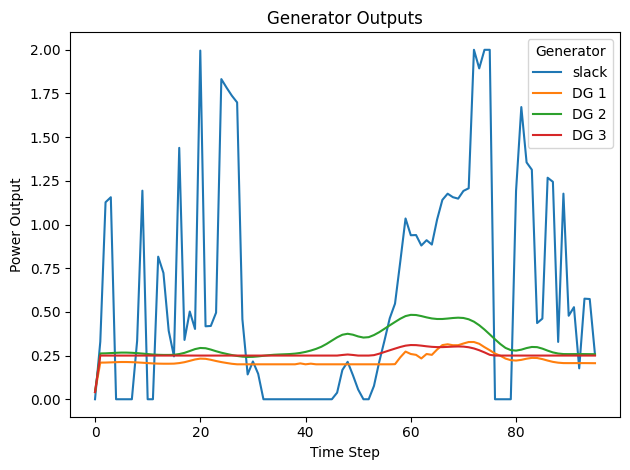

In [317]:
import numpy as np
import matplotlib.pyplot as plt

# 예시: var_values(p_g)로부터 1차원 배열을 얻었다고 가정
flat = np.array(var_values(p_g))  # 실제 환경에 맞게 수정 필요
gen = [0, 1, 2, 3]             # 발전기 개수에 맞게 라벨 설정

# 49행 x len(gen)열로 형태 변환
pp = flat.reshape(T, len(gen))

# 플롯
plt.figure()
for idx, label in enumerate(gen):
    if label == 0:
        plt.plot(pp[:, idx], label= 'slack')
    else:
        plt.plot(pp[:, idx], label=f'DG {label}')
plt.legend(title='Generator')
plt.xlabel('Time Step')
plt.ylabel('Power Output')
plt.title('Generator Outputs')
plt.tight_layout()
plt.show()


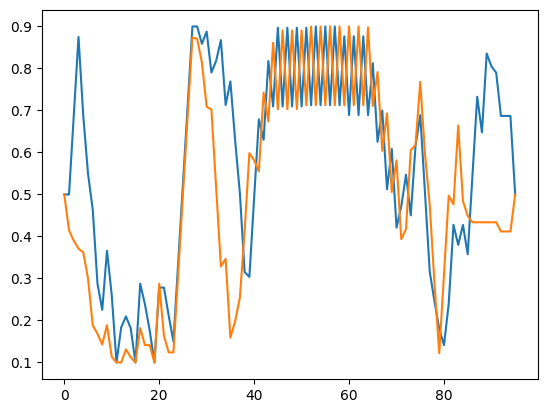

In [318]:
asd = np.array(var_values(soc_e))
asd = asd.reshape(T,len(essdata))
plt.plot(asd)
Pline = []
for i in Pl_full:
     Pline.append(round(i,2))
import scipy.io
# scipy.io.savemat('./matfigures/soc.mat',dict(soc=asd))

In [319]:
soc_e

{(7, 0): <gurobi.Var SOC[7,0] (value 0.5)>,
 (26, 0): <gurobi.Var SOC[26,0] (value 0.5)>,
 (7, 1): <gurobi.Var SOC[7,1] (value 0.5)>,
 (26, 1): <gurobi.Var SOC[26,1] (value 0.41478862956838924)>,
 (7, 2): <gurobi.Var SOC[7,2] (value 0.6875)>,
 (26, 2): <gurobi.Var SOC[26,2] (value 0.39001328163988747)>,
 (7, 3): <gurobi.Var SOC[7,3] (value 0.875)>,
 (26, 3): <gurobi.Var SOC[26,3] (value 0.37102738142412806)>,
 (7, 4): <gurobi.Var SOC[7,4] (value 0.6875218846867)>,
 (26, 4): <gurobi.Var SOC[26,4] (value 0.36229509545273525)>,
 (7, 5): <gurobi.Var SOC[7,5] (value 0.5500124460585447)>,
 (26, 5): <gurobi.Var SOC[26,5] (value 0.30081968245600044)>,
 (7, 6): <gurobi.Var SOC[7,6] (value 0.4637117808953108)>,
 (26, 6): <gurobi.Var SOC[26,6] (value 0.1883106338098517)>,
 (7, 7): <gurobi.Var SOC[7,7] (value 0.28736883439750444)>,
 (26, 7): <gurobi.Var SOC[26,7] (value 0.16830904909158453)>,
 (7, 8): <gurobi.Var SOC[7,8] (value 0.22540928138762487)>,
 (26, 8): <gurobi.Var SOC[26,8] (value 0.14280

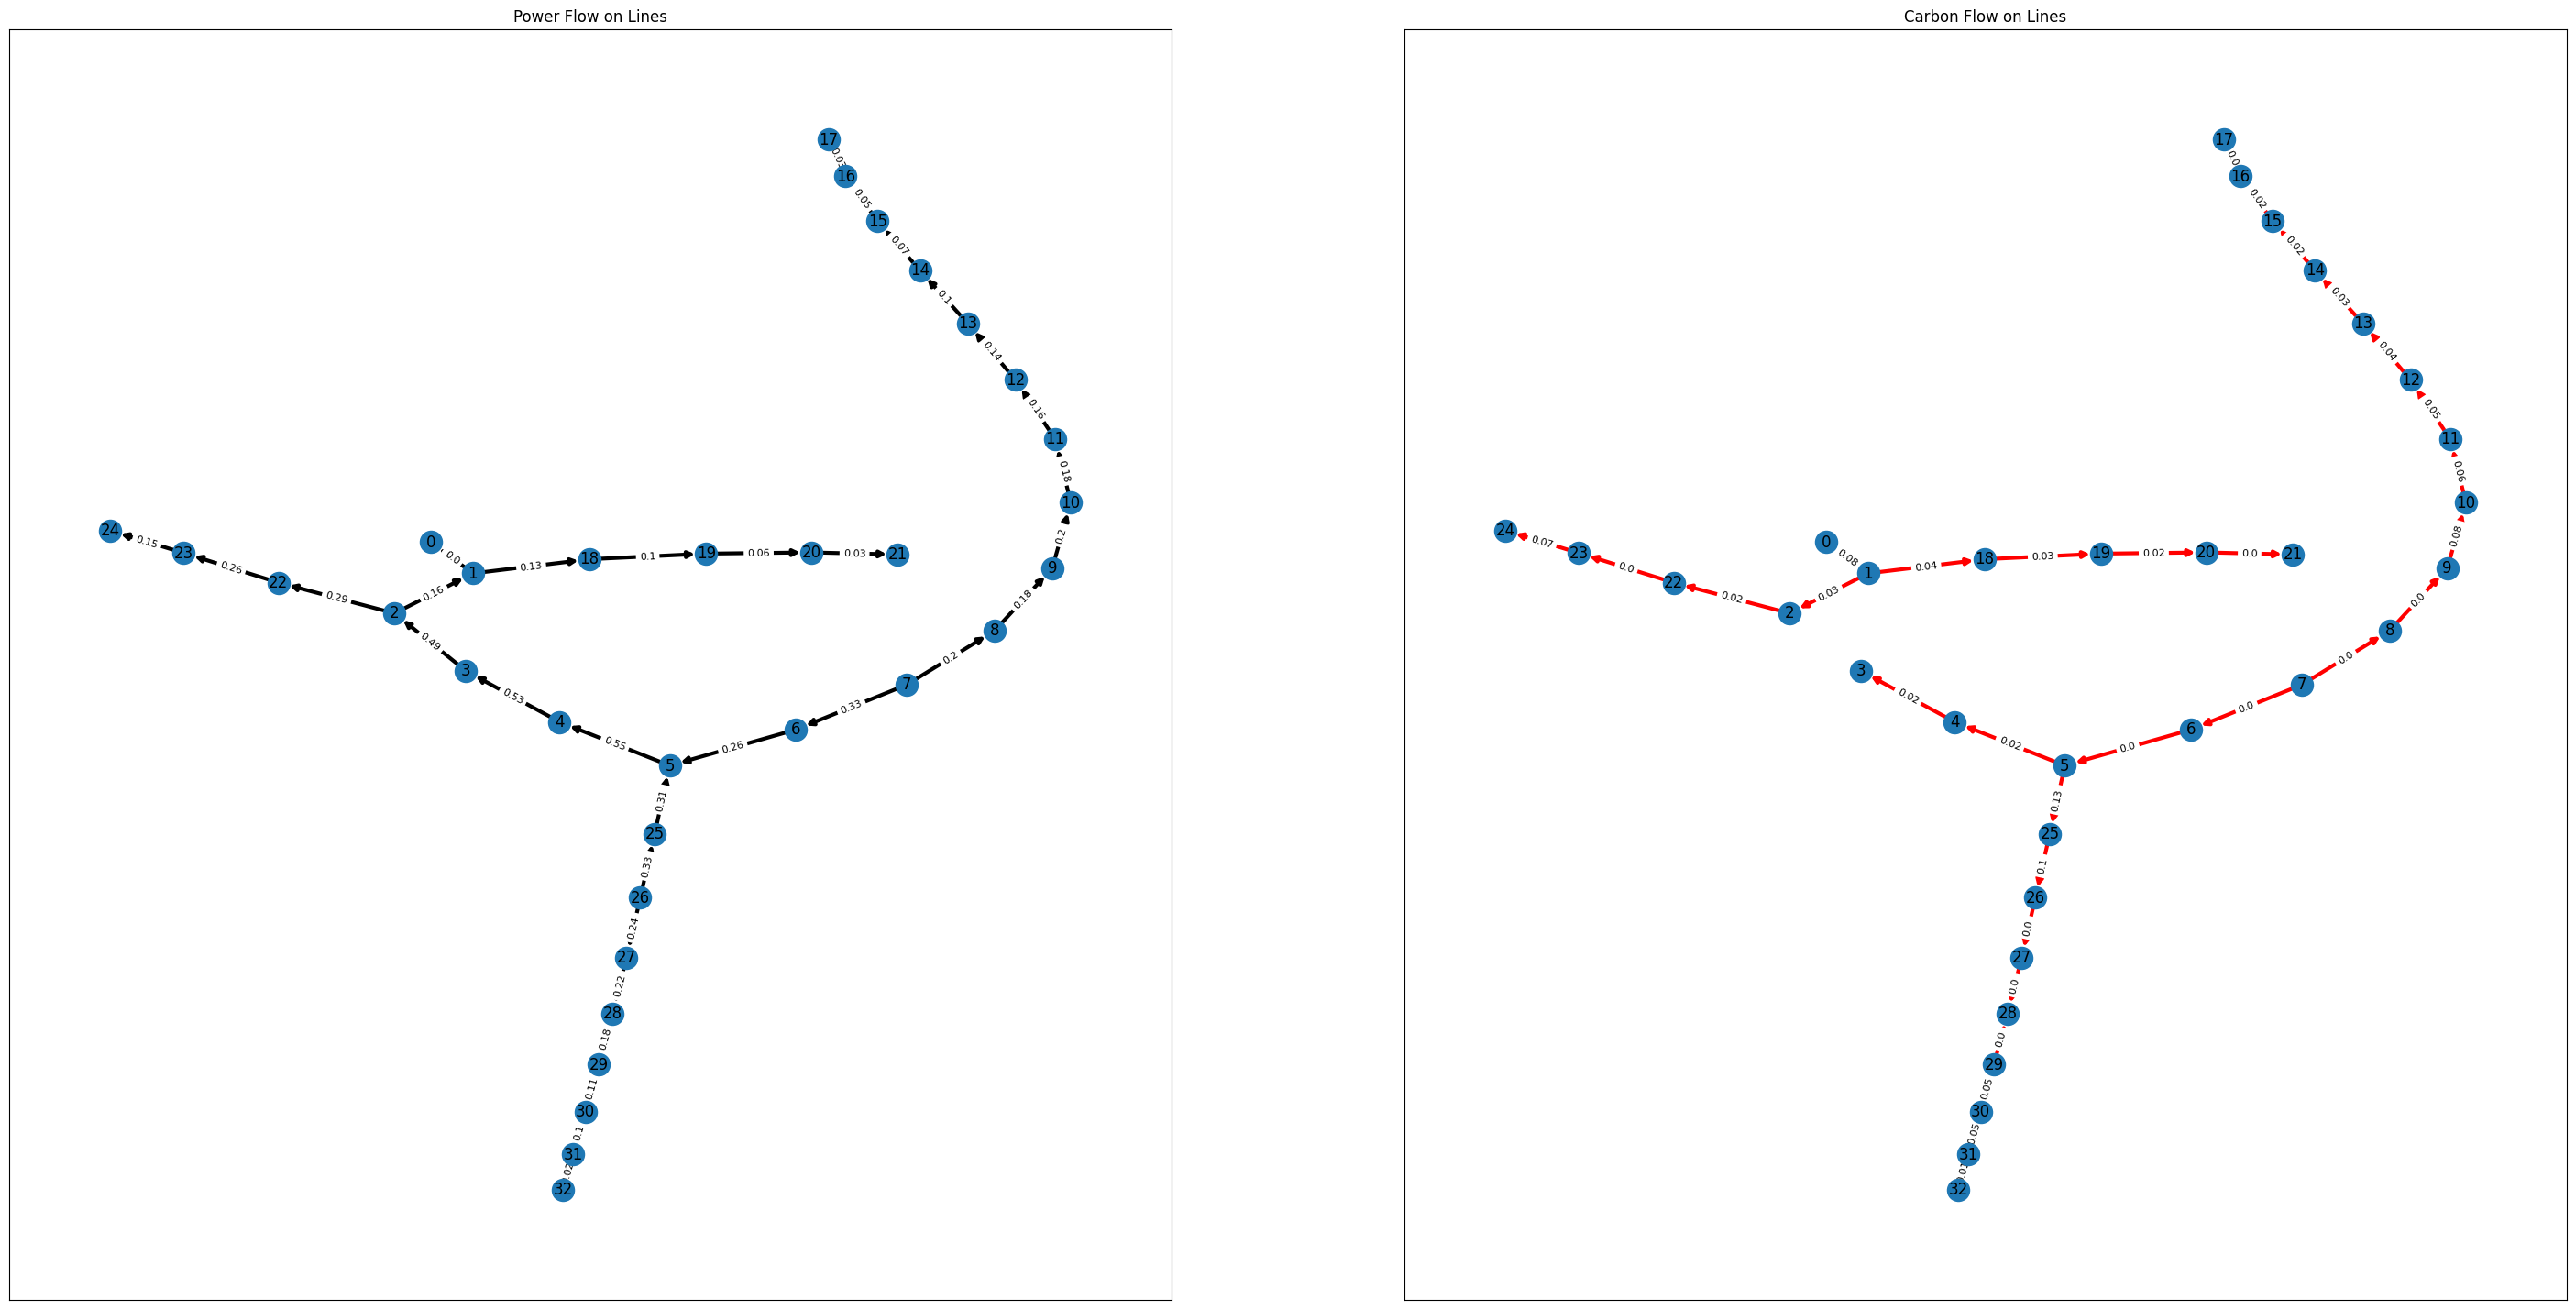

In [320]:
import networkx as nx

Pl_full = var_values(p_ij,MVAbase)
Pline = []
for i in Pl_full:
    Pline.append(round(i,2))
    
plt.figure(figsize=[36,18])
# plt.figure(figsize=[20,5])
plt.subplot(1,2,1)
plt.title('Power Flow on Lines')

# Dummy positioning
F = nx.Graph()
F.add_edges_from(line.index)
pos = nx.spring_layout(F, iterations=100, seed=420)
# pos = nx.multipartite_layout(F)

# Directed flows
G = nx.DiGraph()
# gd = net.bus_geodata
k = 0
#for i in bus.index:
 #   G.add_node(i,pos=(gd.x[i],gd.y[i]))
  #  pos[i] = np.array([gd.x[i],gd.y[i]])
 
for i in line.index:
    # print(i)
    if Pline[k] > 0:
        G.add_edge(i[0],i[1],weight=abs(Pline[k]))
    else:
        G.add_edge(i[1],i[0],weight=abs(Pline[k]))
    k = k+1
# pos = nx.spring_layout(G, iterations=100, seed=4)
nx.draw_networkx(G,pos, with_labels=True, width=3, arrowstyle='-|>')
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

plt.subplot(1,2,2)
plt.title('Carbon Flow on Lines')
# Calculate the Carbon Flow Rate at lines
p_idx = [i for i in line_t_dir if p_hat[i].X > 0]

H = nx.DiGraph()
for i,j,t in p_idx:
    if t==T-1:
        val = w_i[i,t].X*p_hat[i,j,t].X*MVAbase
        H.add_edge(i,j,weight=round(val,2))

p = nx.draw_networkx(H,pos, with_labels=True, width=3, arrowstyle='-|>', edge_color='red')
edge_labels = nx.get_edge_attributes(H, "weight")
q = nx.draw_networkx_edge_labels(H, pos, edge_labels, font_size=8)

In [321]:
import pandas as pd

# 탄소 흐름 데이터 수집
carbon_flow_data = []
p_idx = [i for i in line_t_dir if p_hat[i].X > 0]

for i,j,t in p_idx:
    if t==T-1:  # 마지막 시간대
        val = w_i[i,t].X*p_hat[i,j,t].X*MVAbase
        carbon_flow_data.append({
            'From Bus': i,
            'To Bus': j,
            'Carbon Flow': round(val, 3)
        })

# DataFrame 생성 및 정렬
carbon_df = pd.DataFrame(carbon_flow_data)
carbon_df = carbon_df.sort_values(by=['From Bus', 'To Bus'])

# 표 출력
print("\nCarbon Flow between Buses:")
print(carbon_df)


Carbon Flow between Buses:
    From Bus  To Bus  Carbon Flow
0          0       1        0.076
1          1       2        0.032
16         1      18        0.042
20         2      22        0.025
2          4       3        0.017
3          5       4        0.023
23         5      25        0.127
4          6       5        0.000
5          7       6        0.000
6          7       8        0.000
7          8       9        0.001
8          9      10        0.077
9         10      11        0.059
10        11      12        0.052
11        12      13        0.045
12        13      14        0.031
13        14      15        0.024
14        15      16        0.017
15        16      17        0.000
17        18      19        0.031
18        19      20        0.021
19        20      21        0.000
21        22      23        0.004
22        23      24        0.065
24        25      26        0.101
25        26      27        0.000
26        27      28        0.001
27        29      28

In [322]:
import pandas as pd
import numpy as np

# 이 코드는 notebook 환경에 'net' 객체와 'l30' 배열이 이미 로드되어 있다고 가정합니다.
# 'net.bus'는 각 버스의 기본 부하('Pd', 'Qd')를 포함하는 DataFrame입니다.
# 'l30'은 시간대별 부하 프로파일을 담고 있는 NumPy 배열입니다.

# 시간대별 각 버스의 유효전력 부하(Pd)를 계산합니다.
# np.outer를 사용하여 각 버스의 기본 부하(net.bus['Pd'])와 
# 시간대별 부하 프로파일(l30)의 외적을 효율적으로 계산합니다.
# T=96 시간 단계이므로 l30 배열의 마지막 값은 제외합니다 (l30[:96]).
time_varying_load_pd = pd.DataFrame(
    np.outer(net.bus['Pd'], l30[:96]),
    index=net.bus.index,
    columns=[f'Time_{t}' for t in range(96)]
)

# 동일한 방식으로 무효전력 부하(Qd)도 계산할 수 있습니다.
time_varying_load_qd = pd.DataFrame(
    np.outer(net.bus['Qd'], l30[:96]),
    index=net.bus.index,
    columns=[f'Time_{t}' for t in range(96)]
)


# 계산된 유효전력 부하 DataFrame을 출력하여 확인합니다.
print("--- 각 버스의 시간대별 유효전력 부하 (Pd) ---")
# Jupyter Notebook 환경에서는 display()를 사용하면 더 깔끔하게 보입니다.
# display(time_varying_load_pd)
print(time_varying_load_pd)


# 계산된 무효전력 부하 DataFrame을 출력하여 확인합니다.
print("\n--- 각 버스의 시간대별 무효전력 부하 (Qd) ---")
# display(time_varying_load_qd)
print(time_varying_load_qd)

# 시스템 전체의 시간대별 총 부하를 확인하고 싶다면, 각 DataFrame의 열을 합산하면 됩니다.
total_pd_load = time_varying_load_pd.sum()
print("\n--- 시간대별 시스템 전체 유효전력 부하 ---")
print(total_pd_load)

--- 각 버스의 시간대별 유효전력 부하 (Pd) ---
        Time_0    Time_1    Time_2    Time_3    Time_4    Time_5    Time_6  \
name                                                                         
0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1     0.035617  0.035632  0.035791  0.036134  0.036498  0.036795  0.036776   
2     0.032055  0.032069  0.032212  0.032521  0.032848  0.033116  0.033099   
3     0.042740  0.042759  0.042950  0.043361  0.043797  0.044154  0.044132   
4     0.021370  0.021379  0.021475  0.021681  0.021899  0.022077  0.022066   
5     0.021370  0.021379  0.021475  0.021681  0.021899  0.022077  0.022066   
6     0.071233  0.071265  0.071583  0.072269  0.072996  0.073590  0.073553   
7     0.071233  0.071265  0.071583  0.072269  0.072996  0.073590  0.073553   
8     0.021370  0.021379  0.021475  0.021681  0.021899  0.022077  0.022066   
9     0.021370  0.021379  0.021475  0.021681  0.021899  0.022077  0.022066   
10    0.016027  0.016035  0.0161

--- 시간대별 시스템 전체 유효전력 부하 총합 ---
0     1.323158
1     1.323744
2     1.329651
3     1.342389
4     1.355895
        ...   
91    1.290890
92    1.291628
93    1.291034
94    1.288452
95    1.284910
Name: Total_Pd_Load, Length: 96, dtype: float64


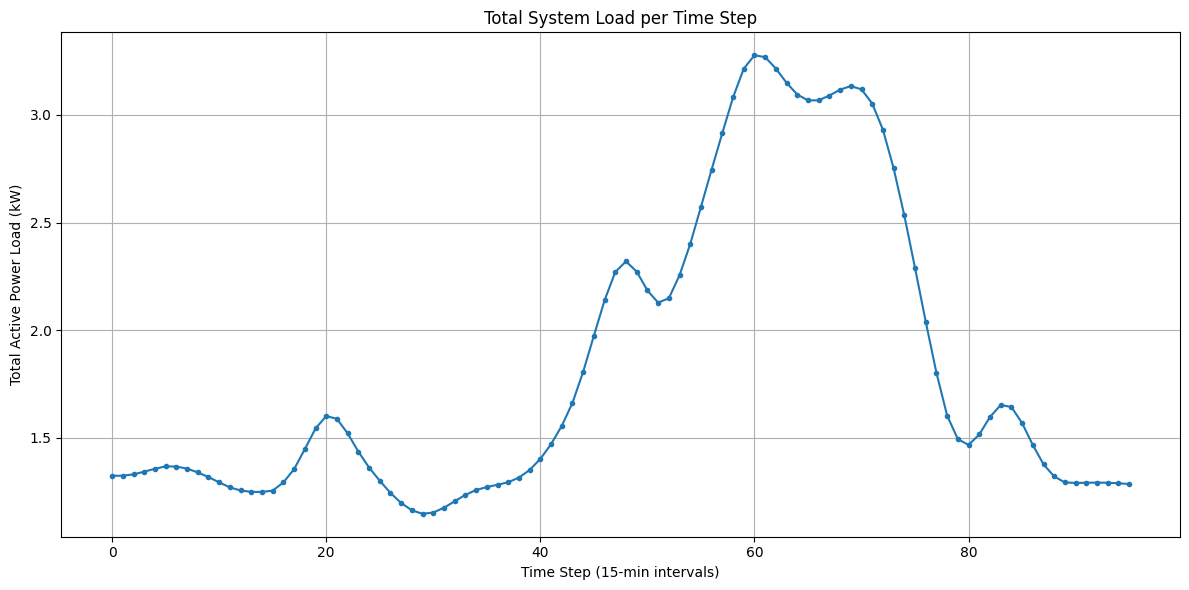

In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 이 코드는 'net' 객체와 'l30' 배열이 노트북 환경에 이미 로드되었다고 가정합니다.

# 1. 각 버스의 시간대별 유효전력 부하(Pd)를 계산합니다.
# np.outer는 각 버스의 기본 부하(net.bus['Pd'])와 
# 시간대별 부하 프로파일(l30)을 곱해주는 효율적인 방법입니다.
# T=96이므로 l30 배열의 96개 값만 사용합니다 (l30[:96]).
time_varying_load_pd = pd.DataFrame(
    np.outer(net.bus['Pd'], l30[:96]),
    index=net.bus.index
)

# 2. 각 시간 단계별로 모든 버스의 부하를 합산합니다 (각 열의 합계를 구함).
total_load_per_timestep = time_varying_load_pd.sum(axis=0)
total_load_per_timestep.name = "Total_Pd_Load"

# 3. 계산된 시간대별 부하 총합을 출력합니다.
print("--- 시간대별 시스템 전체 유효전력 부하 총합 ---")
print(total_load_per_timestep)


# 4. 부하 곡선을 그래프로 시각화합니다.
plt.figure(figsize=(12, 6))
total_load_per_timestep.plot(kind='line', marker='.', linestyle='-')
plt.title('Total System Load per Time Step')
plt.xlabel('Time Step (15-min intervals)')
plt.ylabel('Total Active Power Load (kW)')
plt.grid(True)
plt.tight_layout()
plt.show()

--- 시간대별 부하 상세 (순수 수요, ESS 충전, 총 부하) ---
    Base_Consumer_Load  ESS_Charging_Load  Total_Grid_Load
0             1.323158           0.000000         1.323158
1             1.323744           0.000000         1.323744
2             1.329651           0.600000         1.929651
3             1.342389           0.600000         1.942389
4             1.355895           0.000000         1.355895
..                 ...                ...              ...
91            1.290890           0.000000         1.290890
92            1.291628           0.000000         1.291628
93            1.291034           0.000000         1.291034
94            1.288452           0.000000         1.288452
95            1.284910           0.281747         1.566657

[96 rows x 3 columns]


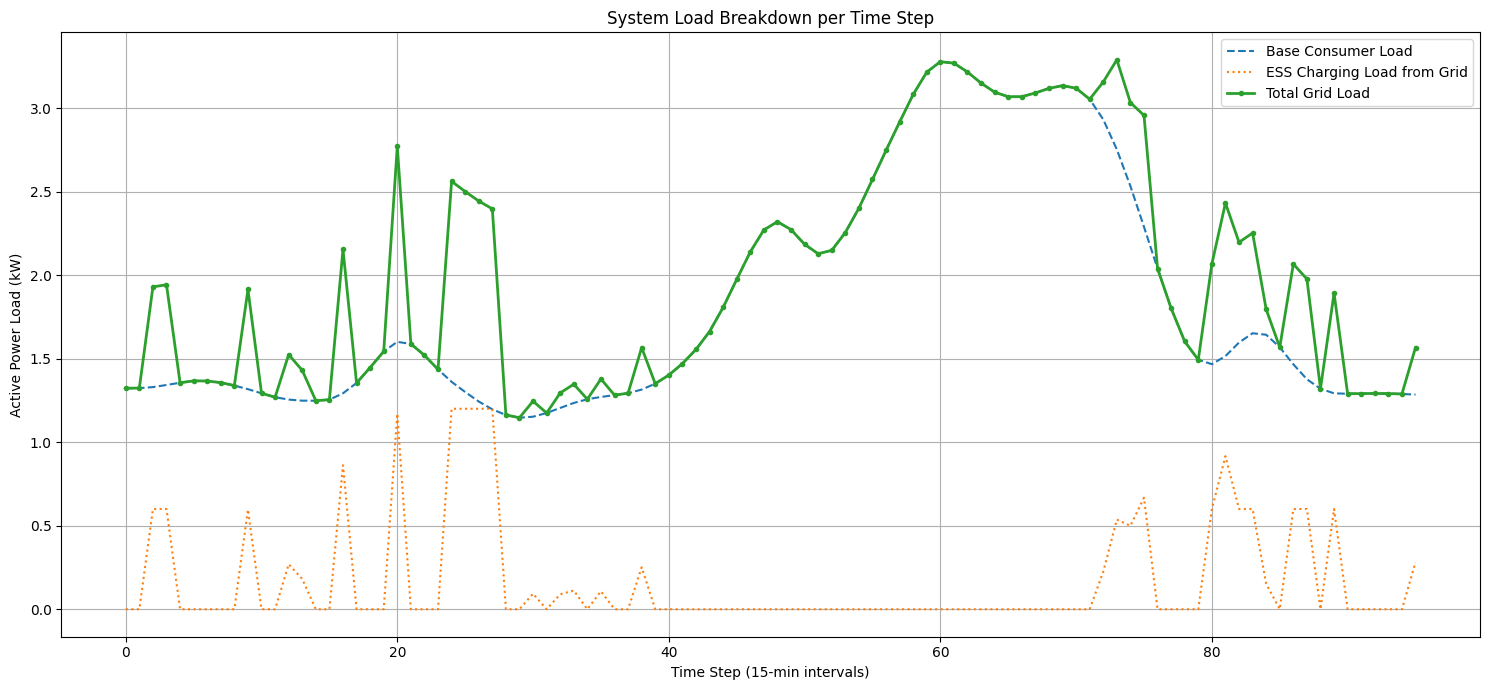

In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 이 코드는 m.optimize()가 성공적으로 실행된 후에 실행되어야 합니다.

try:
    # 1. 이전과 동일하게 각 버스의 '순수 전력 수요'를 계산하고 시간대별로 합산합니다.
    base_consumer_load = pd.Series(
        np.outer(net.bus['Pd'], l30[:96]).sum(axis=0),
        name="Base_Consumer_Load"
    )

    # 2. 최적화 결과에서 'ESS 충전 부하'를 추출합니다.
    # p_ch_grid 변수에서 시간대별로 모든 ESS의 충전량을 합산합니다.
    ess_charging_load = pd.Series(
        [p_ch_grid.sum('*', t).getValue() for t in set_t],
        index=range(96),
        name="ESS_Charging_Load"
    )

    # 3. '총 그리드 부하'를 계산합니다.
    # 총 그리드 부하 = 순수 전력 수요 + ESS 충전 부하
    total_grid_load = base_consumer_load + ess_charging_load
    total_grid_load.name = "Total_Grid_Load"

    # 4. 계산된 부하들을 출력합니다.
    load_df = pd.concat([base_consumer_load, ess_charging_load, total_grid_load], axis=1)
    print("--- 시간대별 부하 상세 (순수 수요, ESS 충전, 총 부하) ---")
    print(load_df)

    # 5. 부하 곡선들을 시각화하여 비교합니다.
    plt.figure(figsize=(15, 7))
    
    load_df['Base_Consumer_Load'].plot(kind='line', label='Base Consumer Load', linestyle='--')
    load_df['ESS_Charging_Load'].plot(kind='line', label='ESS Charging Load from Grid', linestyle=':')
    load_df['Total_Grid_Load'].plot(kind='line', label='Total Grid Load', linewidth=2, marker='.')
    
    plt.title('System Load Breakdown per Time Step')
    plt.xlabel('Time Step (15-min intervals)')
    plt.ylabel('Active Power Load (kW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except NameError:
    print("오류: Gurobi 모델 변수(p_ch_grid)를 찾을 수 없습니다.")
    print("이 코드는 m.optimize()가 성공적으로 실행된 후에 실행해야 합니다.")
except Exception as e:
    print(f"오류가 발생했습니다: {e}")